Attempt to fully vectorise environment creation.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')
sys.path.append('../wurm/')
from vis import plot_envs

In [3]:
SIZE = 12
NUM_ENVS = 4
FOOD_CHANNEL = 0
HEAD_CHANNEL = 1
BODY_CHANNEL = 2
SNAKE_LENGTH = 4

In [4]:
envs = torch.zeros((NUM_ENVS, 3, SIZE, SIZE))

In [5]:
envs[0, HEAD_CHANNEL, 5, 5] = 1
envs[1, HEAD_CHANNEL, 5, 6] = 1
envs[2, HEAD_CHANNEL, 6, 5] = 1
envs[3, HEAD_CHANNEL, 5, 6] = 1

In [6]:
envs[:, HEAD_CHANNEL, :, :]

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [28]:
# snake_filters = torch.Tensor([
#     [
#         [4, 0, 0, 0, 0],
#         [3, 0, 0, 0, 0],
#         [2, 0, 0, 0, 0],
#         [1, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0],
#     ],
#     [
#         [4, 3, 2, 1, 0],
#         [0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0],
#     ],
#     [
#         [0, 0, 0, 0, 0],
#         [1, 0, 0, 0, 0],
#         [2, 0, 0, 0, 0],
#         [3, 0, 0, 0, 0],
#         [4, 0, 0, 0, 0],
#     ],
#     [
#         [0, 1, 2, 3, 4],
#         [0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0],
#     ],
# ]).unsqueeze(1).float()
snake_filters = torch.Tensor([
    [
        [0, 0, 0, 0, 0],
        [0, 0, 4, 0, 0],
        [0, 0, 3, 0, 0],
        [0, 0, 2, 0, 0],
        [0, 0, 1, 0, 0],
    ],
    [
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [4, 3, 2, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 2, 0, 0],
        [0, 0, 3, 0, 0],
        [0, 0, 4, 0, 0],
    ],
    [
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 2, 3, 4],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
]).unsqueeze(1).float()
snake_filters = torch.Tensor([
    [
        [0, 0, 0],
        [1, 2, 3],
        [0, 0, 0],
    ],
    [
        [0, 0, 0],
        [3, 2, 1],
        [0, 0, 0],
    ],
    [
        [0, 3, 0],
        [0, 2, 0],
        [0, 1, 0],
    ],
    [
        [0, 1, 0],
        [0, 2, 0],
        [0, 3, 0],
    ],
]).unsqueeze(1).float()
snake_filters.shape

torch.Size([4, 1, 3, 3])

In [29]:
random_directions = torch.randint(snake_filters.shape[0], (NUM_ENVS, ))
random_directions_onehot = torch.FloatTensor(NUM_ENVS, snake_filters.shape[0])
random_directions_onehot.zero_()
random_directions_onehot.scatter_(1, random_directions.unsqueeze(-1), 1)

tensor([[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])

In [33]:
F.conv2d(envs[:, HEAD_CHANNEL:HEAD_CHANNEL+1, :, :], snake_filters, padding=1).shape

torch.Size([4, 4, 12, 12])

In [34]:
temp = torch.einsum('bchw,bc->bhw', [
    F.conv2d(envs[:, HEAD_CHANNEL:HEAD_CHANNEL+1, :, :], snake_filters, padding=1),
    random_directions_onehot
]).unsqueeze(1)
envs[:, BODY_CHANNEL:BODY_CHANNEL+1, :, :] = temp
temp

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0

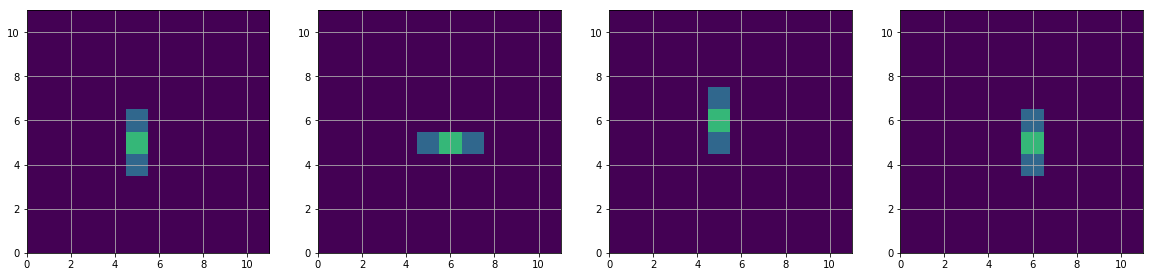

In [35]:
plot_envs(envs, range(4), mode='multi')

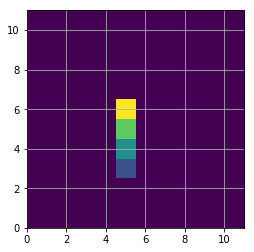

In [26]:
plt.imshow(temp[0, 0].numpy())
plt.xlim((0, SIZE-1))
plt.ylim((0, SIZE-1))
plt.grid()

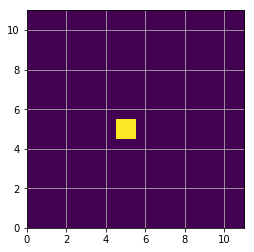

In [27]:
plt.imshow(envs[0, 1].numpy())
plt.xlim((0, SIZE-1))
plt.ylim((0, SIZE-1))
plt.grid()

In [13]:
torch.stack([
    torch.arange(NUM_ENVS),
    torch.zeros((NUM_ENVS,)).long(),
    torch.randint(1 + SNAKE_LENGTH, SIZE - (1 + SNAKE_LENGTH), size=(NUM_ENVS,)),
    torch.randint(1 + SNAKE_LENGTH, SIZE - (1 + SNAKE_LENGTH), size=(NUM_ENVS,))
]).t()

tensor([[0, 0, 6, 5],
        [1, 0, 5, 6],
        [2, 0, 5, 6],
        [3, 0, 5, 6]])

In [14]:
torch.zeros((NUM_ENVS,))

tensor([0., 0., 0., 0.])

In [15]:
torch.randint(1 + SNAKE_LENGTH, SIZE - (1 + SNAKE_LENGTH), size=(NUM_ENVS,))

tensor([6, 5, 6, 6])